# Analysis of the fluorescence recovery

The script gets its input from a config yml configuration file:
```yaml
filelist: /path/to/filelist.csv
summary: /path/to/results.csv
```

In a first section, the time signal are plt

## Load dataset

In [1]:
from pathlib import Path
import yaml
import numpy as np
import pandas as pd

def madstd(x):
    """Maximum abosolute deviation of the standard deviation"""
    return 1.4826 * np.median(np.abs(x-np.median(x)))

# load the configuration file
with open('config.yml', 'r') as file:
    config = yaml.safe_load(file)

filelist = pd.read_csv(config['filelist'])

# order the files
filelist['Parasite'] = filelist['Filename'].transform(lambda x: int(x.split('_')[0].replace('Parasite','')))
filelist.index = filelist['Parasite']
filelist = filelist.sort_index()


In [2]:
# load the individual csv files
df = []
folder = Path(config['filelist']).parent
for k,row in enumerate(filelist.iloc):
    path = folder / row['Filename'].replace('.tif','-profile.csv')    
    tmp = pd.read_csv(path)    
    tmp['Parasite'] = row['Parasite']
    tmp['file'] = row['Filename']
    x = tmp['Mean intensity']
    tmp['Normalized intensity'] = 100 * (x - x.min()) / (x.max() -x.min())
    m = tmp['Model']
    tmp['Normalized model'] = 100 * (m - x.min()) / (x.max() - x.min())
    df.append(tmp)
df = pd.concat(df,ignore_index=True)


## Visualization of intensity measurement

[Text(0.5, 0, 'Time p.i. [min]'),
 Text(0, 0.5, '% max GFP intensity around Gondi vacuole')]

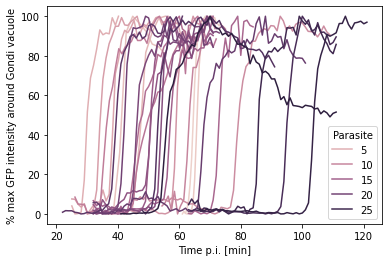

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(data=df, x='Time [min]', y='Normalized intensity', hue='Parasite')
plt.gca().set(xlabel='Time p.i. [min]',ylabel='% max GFP intensity around Gondi vacuole')

<AxesSubplot:xlabel='Time [min]', ylabel='Normalized model'>

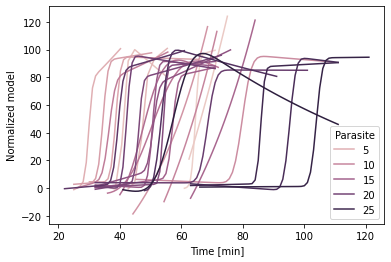

In [4]:
sns.lineplot(data=df, x='Time [min]', y='Normalized model', hue='Parasite')

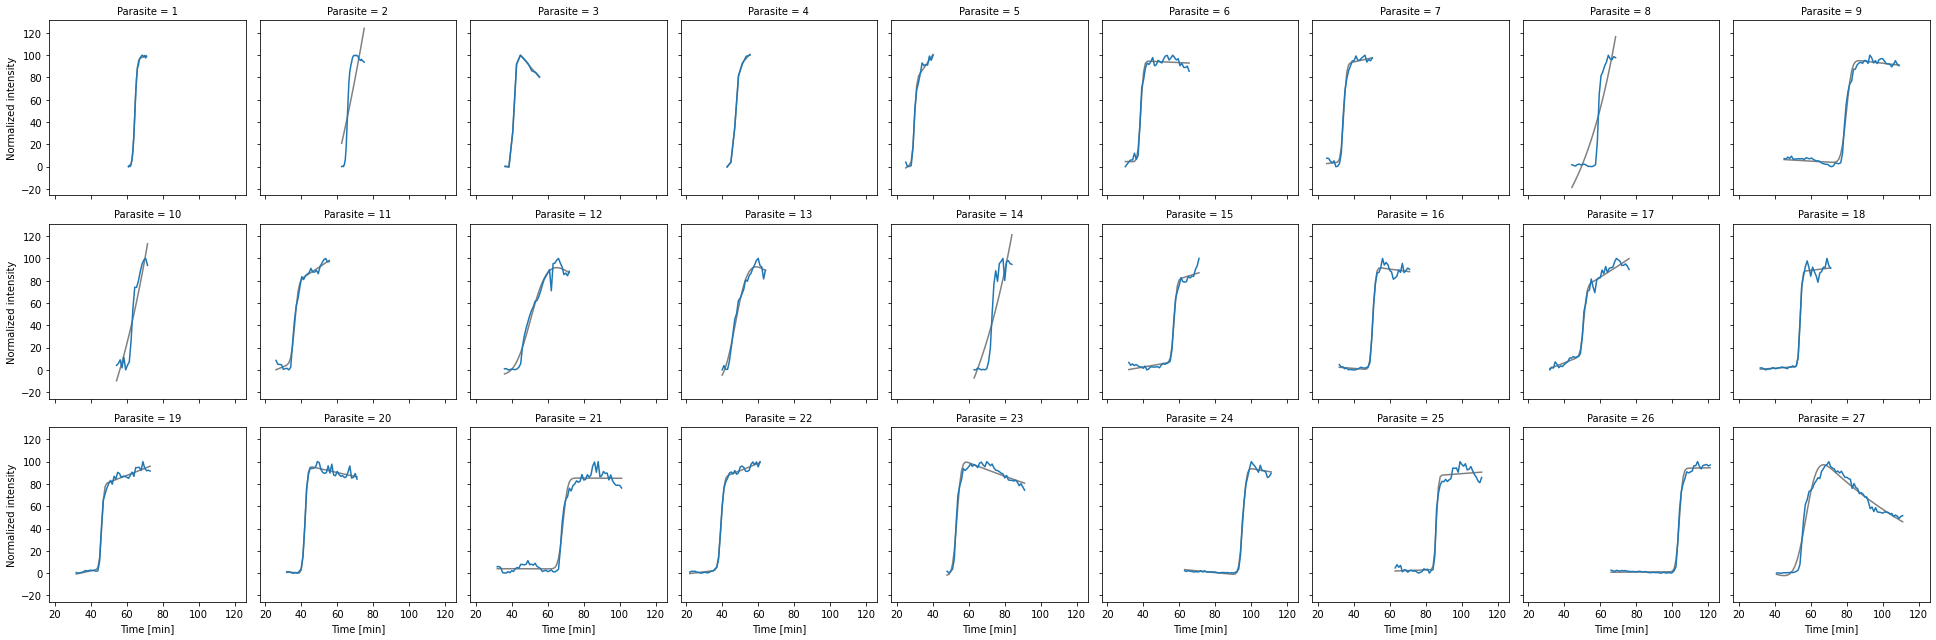

In [5]:
g = sns.FacetGrid(df, col="Parasite", col_wrap=9, despine=False)
g.map(sns.lineplot,'Time [min]', 'Normalized model',color='gray')
g.map(sns.lineplot,'Time [min]', 'Normalized intensity')
#g.figure.subplots_adjust(wspace=0, hspace=0)

## Statistical analysis of model parameters


In [55]:
ds = pd.read_csv(config['summary'])
ds = pd.merge(ds,filelist[['Filename','Parasite']],left_on='Image',right_on='Filename')
ds.index = ds['Parasite']
ds = ds.sort_index()
ds.head()



,Image,Start time [min],First frame,Time mid point [min],Time constant [min],5%-95% recovery time [min],Intensity amplitude [au],Intensity offset [au],Photo-bleaching [min],R squared,Filename,Parasite
Parasite,,,,,,,,,,,,
1,Parasite1_from video on manuscript_211013_GFPR...,60,1,64.556704,1.443420,3.357396,8.387091,112.651794,-1145.050289,0.999249,Parasite1_from video on manuscript_211013_GFPR...,1
2,Parasite2_from video on manuscript_211013_GFPR...,60,4,65.789712,1.354199,3.149867,16.217901,124.299174,inf,0.997520,Parasite2_from video on manuscript_211013_GFPR...,2
3,Parasite3_211013_GFPRNF_RHtomato_30min_2min001...,30,2,41.173315,1.782068,4.145089,24.376246,166.815427,226.625932,0.999551,Parasite3_211013_GFPRNF_RHtomato_30min_2min001...,3
4,Parasite4_211013_GFPRNF_RHtomato_30min_2min001...,30,5,47.400938,1.806902,4.202854,12.597389,111.692960,-226.290427,0.999464,Parasite4_211013_GFPRNF_RHtomato_30min_2min001...,4
5,Parasite5_231129_23MIN_1min.nd2 - 231129_23MIN...,23,1,29.852595,1.353960,3.149311,44.583354,165.513664,-78.449952,0.992833,Parasite5_231129_23MIN_1min.nd2 - 231129_23MIN...,5


Text(0.5, 0.98, 'Distribution of the model parameters')

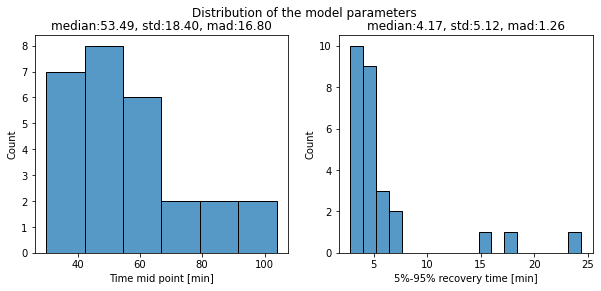

In [21]:
plt.figure(figsize=(10,4))
plt.subplot(121)
sns.histplot(ds, x='Time mid point [min]')
t1 = ds['Time mid point [min]']
plt.title(f'median:{t1.median():.2f}, std:{t1.std():.2f}, mad:{madstd(t1):.2f}')
plt.subplot(122)
sns.histplot(ds, x='5%-95% recovery time [min]')
t2 = ds['5%-95% recovery time [min]']
plt.title(f'median:{t2.median():.2f}, std:{t2.std():.2f}, mad:{madstd(t2):.2f}');
plt.suptitle('Distribution of the model parameters')

## Visualization of the model

9


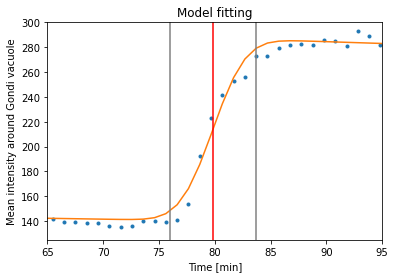

In [37]:
# select a single curve
pid = 9
sel = df[df['Parasite']==pid]
plt.plot(sel['Time [min]'], sel['Mean intensity'],'.')
plt.plot(sel['Time [min]'], sel['Model'])
plt.gca().set(title='Model fitting', xlabel='Time [min]', ylabel='Mean intensity around Gondi vacuole')
#a = ds['Intensity offset [au]'][pid]
#b = ds['Intensity amplitude [au]'][pid]
c = ds['Time mid point [min]'][pid]
t0 = ds['5%-95% recovery time [min]'][pid]
#plt.plot(sel['Time [min]'], a * np.ones(len(sel['Time [min]'])))
#plt.plot(c * np.ones(2), np.linspace(120,130,2))
#plt.plot(np.linspace(c-t0/2,c+t0/2,2),[125,125])
plt.plot([c-t0/2,c-t0/2],[125,300],color='gray')
plt.plot([c+t0/2,c+t0/2],[125,300],color='gray')
plt.plot([c,c],[125,300],color='red')
plt.axis([65,95,125,300])
print(ds['Parasite'][pid])

## Interpolation of intensity on common time sampling

Text(42.0, 0.5, 'Parasite')

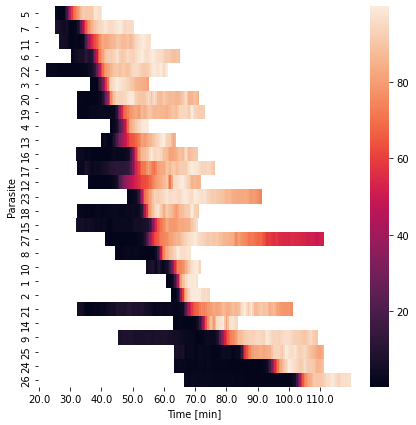

In [9]:
t = np.arange(20,120,0.5)
dst = {}
lng = []
for n,g in df.groupby('Parasite'):         
    tg = g['Time [min]']
    fg =  g['Normalized intensity']
    f = np.interp(t, tg, fg)
    f[t<tg.min()] = np.NaN
    f[t>tg.max()] = np.NaN
    dst[n] = f
    

ptable = pd.DataFrame(dst)
ptable = ptable.reindex(columns=ptable.columns[np.argsort(ds['Time mid point [min]'])])
ptable.index = t
plt.figure(figsize=(7,7))
sns.heatmap(ptable.transpose(),xticklabels=20)
plt.xlabel('Time [min]')
plt.ylabel('Parasite')

In [10]:
ptable = pd.DataFrame(dst)
ptable.index = t
ptable.to_csv(folder/'interpolated_intensities.csv')

## Estimation of model parameters from intensity
Re-estimate the model instead of using the model saved in the summary.

In [59]:
from scipy.optimize import curve_fit
from scipy.special import erf
from math import exp

def fun(x,a,b,c,d,e):
    return ( a + b * erf((x-c) / d) ) * np.exp(-e*x)

t = np.arange(20,120,0.5)

mdl = []
newdf = []
mdl2 = []
for n,g in df.groupby('Parasite'): 
    tg = np.array(g['Time [min]'])
    fg = np.array(g['Mean intensity'])
    a = fg.min()
    b = fg.max()
    p0 = np.array([
        0.5 * (a + b), 
        (b - a),
        np.array(tg[(fg > (a+b)/2.)])[0],
        1,#np.array(tg[(fg > (0.9*a+0.1*b)) & (fg < (0.1*a+0.9*b))]).ptp()/2.3,
        0
        ])    
    popt, pcov = curve_fit(fun, tg, fg, p0)        
    mdl.append({
        'Parasite':n,        
        'Time mid point [min]':popt[2],
        'Time constant [min]':popt[3],
        '5%-95% recovery time [min]':2.3*popt[3],
        'Intensity amplitude [au]':popt[1],
        'Intensity offset [au]':popt[0],
        'Photo-bleaching [min]':1/popt[4]
    })
    g['Model'] = fun(tg,*popt)
    g['Normalized model'] = 100*(g['Model'] - g['Model'].min()) / (g['Model'].max() - g['Model'].min())
    newdf.append(g)
    mdl2.append(pd.DataFrame({'Parasite':n, 'Model':fun(t, *popt),'Time [min]':t,'Normalized model':100*fun(t,0.5,0.5,popt[2],popt[3],0)}))
    #plt.plot(tg,fg)
    #plt.plot(tg,fun(tg,*popt))
    #plt.show()
df = pd.concat(newdf)
ds2 = pd.DataFrame.from_records(mdl)
mdl2 = pd.concat(mdl2)


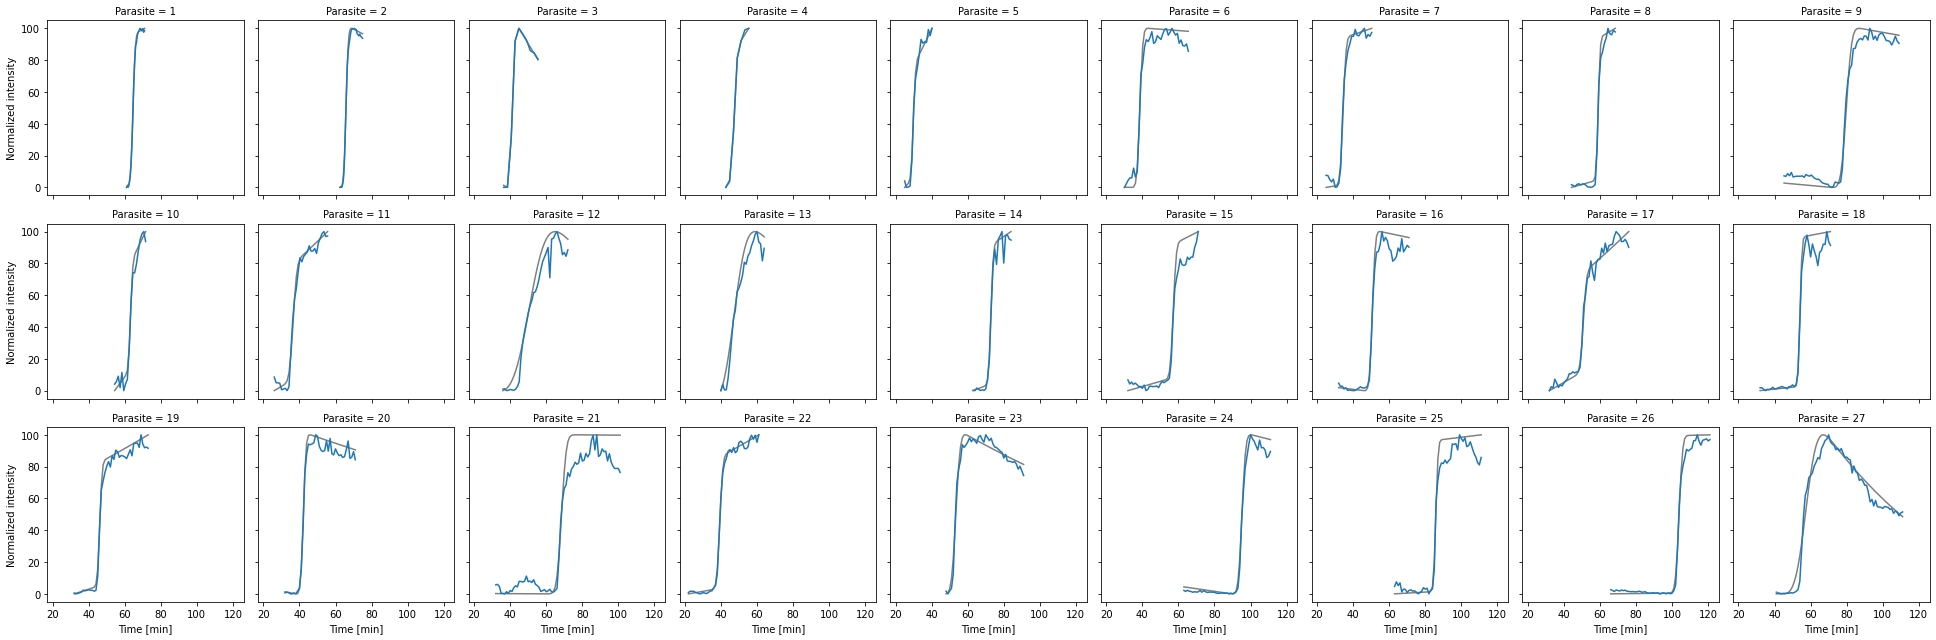

In [12]:
g = sns.FacetGrid(df, col="Parasite", col_wrap=9, despine=False)
g.map(sns.lineplot,'Time [min]', 'Normalized model',color='gray')
g.map(sns.lineplot,'Time [min]', 'Normalized intensity')

Text(0.5, 1.0, 'Interpolated intensities')

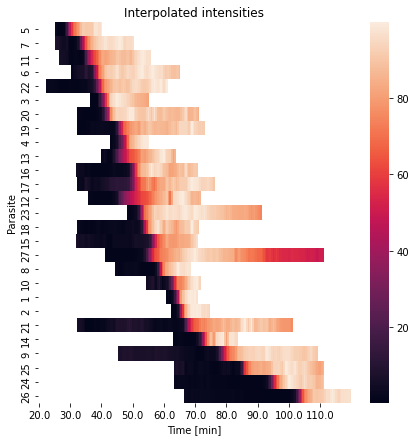

In [13]:

t = np.arange(20,120,0.5)
dst = {}
lng = []
for n,g in df.groupby('Parasite'):         
    tg = g['Time [min]']
    fg =  g['Normalized intensity']
    f = np.interp(t, tg, fg)
    f[t<tg.min()] = np.NaN
    f[t>tg.max()] = np.NaN
    dst[n] = f
    
ptable = pd.DataFrame(dst)
ptable = ptable.reindex(columns=ptable.columns[np.argsort(ds['Time mid point [min]'])])
ptable.index = t
plt.figure(figsize=(7,7))
sns.heatmap(ptable.transpose(),xticklabels=20)
plt.xlabel('Time [min]')
plt.ylabel('Parasite')
plt.title('Interpolated intensities')

<AxesSubplot:xlabel='Time [min]', ylabel='Parasite'>

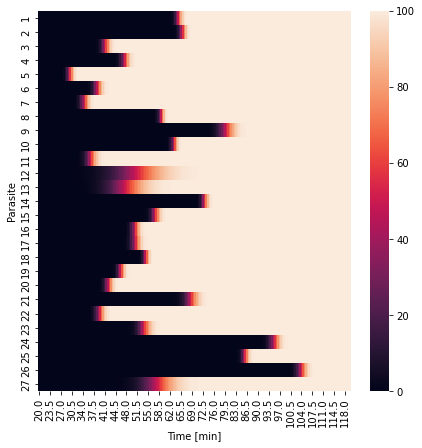

In [61]:
plt.figure(figsize=(7,7))
ptable = mdl2.pivot_table('Normalized model','Time [min]','Parasite')
#ptable = ptable.reindex(columns=ptable.columns[np.argsort(ds2['Time mid point [min]'])])
sns.heatmap(ptable.transpose())

Text(0.5, 0.98, 'Distribution of the model parameters (re estimated)')

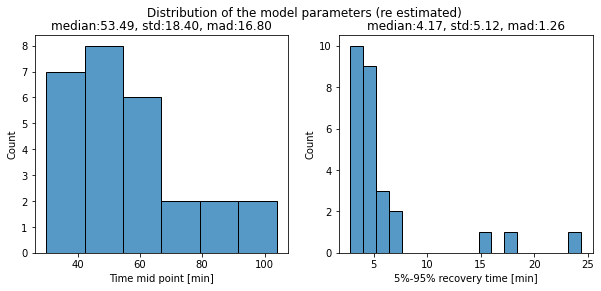

In [52]:
plt.figure(figsize=(10,4))
plt.subplot(121)
sns.histplot(ds2, x='Time mid point [min]')
t1 = ds2['Time mid point [min]']
plt.title(f'median:{t1.median():.2f}, std:{t1.std():.2f}, mad:{madstd(t1):.2f}')
plt.subplot(122)
sns.histplot(ds2, x='5%-95% recovery time [min]')
t2 = ds2['5%-95% recovery time [min]']
plt.title(f'median:{t2.median():.2f}, std:{t2.std():.2f}, mad:{madstd(t2):.2f}');
plt.suptitle('Distribution of the model parameters (re estimated)');

In [58]:
ds2.to_csv(folder / 'reestimated_parameters.csv',index=False)